# Deep Learning Assignment 1 - Transfer Learning

**Author:**
Arian Ghadirzadeh

---

In this notebook, I tried different ways of training a CNN to classify cats and dogs.  
First I trained from scratch, and then I used transfer learning with a model trained on Stanford Dogs.

Experiments:

- **1a**: Train CNN from scratch on Cats vs Dogs
- **1b**: Train CNN from scratch on Stanford Dogs (multi-class)
- **2**: Transfer learning by replacing only the output layer
- **3**: Transfer learning + retrain first two convolutional layers
- **4**: Transfer learning + retrain last two convolutional layers

---


## Imports


In [68]:
import os
import shutil
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers, Input

# Preparation


In [69]:
source_dir = Path("kagglecatsanddogs_3367a/PetImages")
target_dir = Path("data/cats_and_dogs")

train_dir = target_dir / "train"
val_dir = target_dir / "validation"

if target_dir.exists():
    shutil.rmtree(target_dir)

for category in ["Cat", "Dog"]:
    for split in ["train", "validation"]:
        os.makedirs(target_dir / split / category.lower())

for category in ["Cat", "Dog"]:
    img_dir = source_dir / category
    images = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]
    random.shuffle(images)
    images = images[:2000]

    for i, img_name in enumerate(images):
        src_path = img_dir / img_name
        try:
            if i < 1600:
                dst_path = train_dir / category.lower() / img_name
            else:
                dst_path = val_dir / category.lower() / img_name
            shutil.copyfile(src_path, dst_path)
        except Exception as e:
            print(f"Error copying {img_name}: {e}")

In [70]:
def clean_broken_images(directory):
    removed = 0
    for root, _, files in os.walk(directory):
        for filename in files:
            file_path = os.path.join(root, filename)
            try:
                img = Image.open(file_path)
                img.verify()
            except Exception as e:
                print(f"Removing corrupted file: {file_path}")
                os.remove(file_path)
                removed += 1
    print(f"Total corrupted files removed: {removed}")

clean_broken_images('data/cats_and_dogs/train')
clean_broken_images('data/cats_and_dogs/validation')

Total corrupted files removed: 0
Total corrupted files removed: 0


## Experiment 1a - Train from Scratch (Cats vs Dogs)

Here I train a CNN from scratch using the Cats vs Dogs dataset.  
This helps set a baseline to compare with transfer learning later.


In [71]:
base_dir = 'data/cats_and_dogs'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

In [72]:
# Image size and batch config
img_height, img_width = 180, 180
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# Build CNN model
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

# Save the model
Path("models").mkdir(exist_ok=True)
model.save('models/base_model.h5')

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/30


/Users/hossein/.pyenv/versions/3.9.18/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.5346 - loss: 0.6948 - val_accuracy: 0.5612 - val_loss: 0.6726
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 0.6343 - loss: 0.6376 - val_accuracy: 0.6750 - val_loss: 0.6161
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.6938 - loss: 0.5793 - val_accuracy: 0.6888 - val_loss: 0.5959
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 0.7379 - loss: 0.5369 - val_accuracy: 0.7038 - val_loss: 0.5688
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.7508 - loss: 0.5134 - val_accuracy: 0.6925 - val_loss: 0.5788
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.7625 - loss: 0.4781 - val_accuracy: 0.7337 - val_loss: 0.5513
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.8010 - loss: 0.4466 - val_accuracy: 0.7063 - val_loss: 0.5532
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.8184 - loss: 0.4095 - val

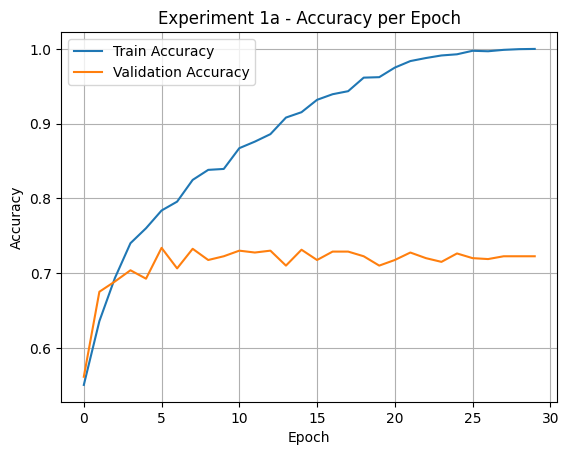

In [74]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Experiment 1a - Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

Train accuracy goes high quickly, and validation is around 74%. Some overfitting but not bad.


## Experiment 1b - Stanford Dogs (Multi-class)

Now I train the same model on Stanford Dogs to classify dog breeds (120 classes).  
I used only 10% of the data and 10 epochs to save time.  
This model is used later for transfer learning.


In [ ]:
# Load 20% of Stanford Dogs dataset for fast training
(train_ds, val_ds), ds_info = tfds.load(
    'stanford_dogs',
    split=['train[:15%]', 'train[15%:20%]'],
    as_supervised=True,
    with_info=True
)

img_height, img_width = 180, 180
batch_size = 32

# Preprocessing: resize and normalize
def preprocess(image, label):
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

model_dogs = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(ds_info.features['label'].num_classes, activation='softmax')  # 120 classes
])


model_dogs.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_dogs = model_dogs.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

model_dogs.save('models/stanford_dogs_multiclass_model.h5')

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.0129 - loss: 4.8103 - val_accuracy: 0.0067 - val_loss: 4.7878
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.0193 - loss: 4.7741 - val_accuracy: 0.0050 - val_loss: 4.7915
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.0263 - loss: 4.7449 - val_accuracy: 0.0133 - val_loss: 4.7907
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.0498 - loss: 4.6664 - val_accuracy: 0.0133 - val_loss: 4.8215
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.0661 - loss: 4.5097 - val_accuracy: 0.0167 - val_loss: 4.8785
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.0982 - loss: 4.2227 - val_accuracy: 0.0150 - val_loss: 5.0065
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.1975 - loss: 3.7869 - val_accuracy: 0.0217 - val_loss: 5.1685
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.2939 - loss: 3.2392 - val_accuracy: 0.

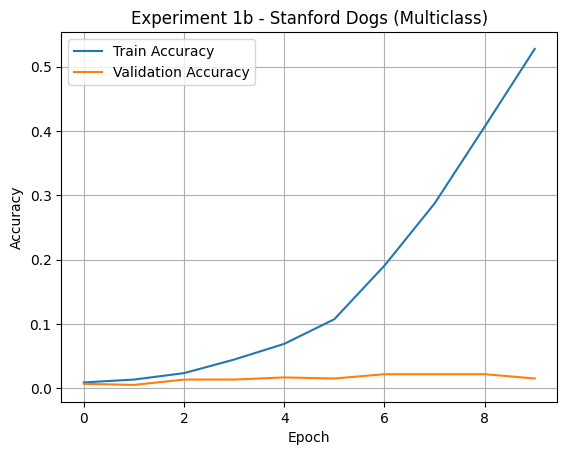

In [76]:
plt.plot(history_dogs.history['accuracy'], label='Train Accuracy')
plt.plot(history_dogs.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Experiment 1b - Stanford Dogs (Multiclass)')
plt.legend()
plt.grid(True)
plt.show()

Train improves a lot, but val stays low (~2–3%). It's expected with limited data.


## Experiment 2 - Transfer Learning (Only Output Layer)

I load the Stanford Dogs model and just replace the output layer for binary classification (cats vs dogs).  
Only the output layer is trainable, the rest is frozen.


In [ ]:
# Load a subset of the Stanford Dogs dataset
(train_ds, val_ds), ds_info = tfds.load(
    'stanford_dogs',
    split=['train[:30%]', 'train[30%:40%]'],
    as_supervised=True,
    with_info=True
)

img_height, img_width = 180, 180
batch_size = 32

def preprocess(image, label):
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

model_sd = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(ds_info.features['label'].num_classes, activation='softmax')
])

model_sd.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_sd = model_sd.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

model_sd.save('models/stanford_dogs_model.h5')

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 0.0082 - loss: 4.8010 - val_accuracy: 0.0108 - val_loss: 4.7858
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.0142 - loss: 4.7814 - val_accuracy: 0.0117 - val_loss: 4.7822
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 0.0126 - loss: 4.7597 - val_accuracy: 0.0133 - val_loss: 4.7702
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 0.0283 - loss: 4.7056 - val_accuracy: 0.0142 - val_loss: 4.7523
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 0.0390 - loss: 4.5981 - val_accuracy: 0.0175 - val_loss: 4.7585
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.0675 - loss: 4.4207 - val_accuracy: 0.0192 - val_loss: 4.7837
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.1061 - loss: 4.1549 - val_accuracy: 0.0167 - val_loss: 4.8315
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.1573 - loss: 3

In [ ]:
# Load the Sequential model (this is the tricky part)
base_seq_model = load_model('models/stanford_dogs_multiclass_model.h5')

# Rebuild the same model with Functional API
inputs = Input(shape=(180, 180, 3))
x = base_seq_model.layers[0](inputs)
for layer in base_seq_model.layers[1:-1]:
    x = layer(x)

# Add new output layer for binary classification
new_output = layers.Dense(1, activation='sigmoid')(x)

# Build the new functional model
model_tl = Model(inputs=inputs, outputs=new_output)

# Freeze all base layers
for layer in base_seq_model.layers:
    layer.trainable = False

model_tl.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_tl = model_tl.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

model_tl.save('models/exp2_transfer_learning_output_only.h5')

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5148 - loss: 1.4504 - val_accuracy: 0.5200 - val_loss: 1.2377
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5140 - loss: 1.2399 - val_accuracy: 0.5188 - val_loss: 1.1464
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5149 - loss: 1.1315 - val_accuracy: 0.5200 - val_loss: 1.0989
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.4938 - loss: 1.1134 - val_accuracy: 0.5275 - val_loss: 1.0665
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5010 - loss: 1.0822 - val_accuracy: 0.5300 - val_loss: 1.0382
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5040 - loss: 1.0458 - val_accuracy: 0.5312 - val_loss: 1.0133
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5083 - loss: 0.9937 - val_accuracy: 0.5250 - val_loss: 0.9902
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5133 - loss: 0.9858 - val_accu

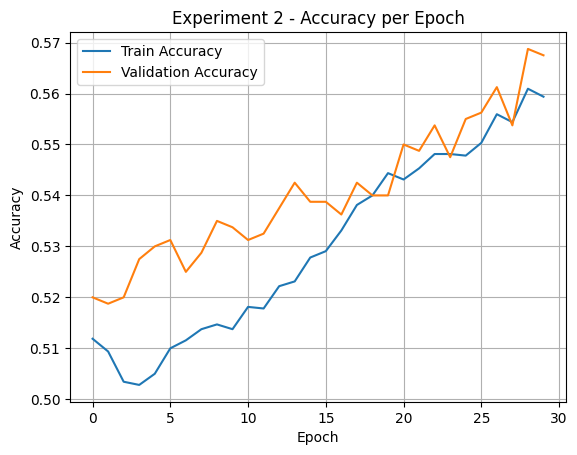

In [ ]:
plt.plot(history_tl.history['accuracy'], label='Train Accuracy')
plt.plot(history_tl.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Experiment 2 - Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

Accuracy stays low. Not enough learning since only the top layer changed.


## Experiment 3 - Output + First 2 Conv Layers

This time I also retrain the first two conv layers.  
This helps the model learn low-level features for the new dataset.


# Only first few conv layers + output layer are trainable


In [80]:
# Load base model trained on Stanford Dogs
base_seq_model = load_model('models/stanford_dogs_multiclass_model.h5')

# Rebuild with Functional API
inputs = Input(shape=(180, 180, 3))
x = base_seq_model.layers[0](inputs)
x = base_seq_model.layers[1](x)  # Conv1
x = base_seq_model.layers[2](x)  # Pool1
x = base_seq_model.layers[3](x)  # Conv2
x = base_seq_model.layers[4](x)  # Pool2

# Apply the rest of the layers except the final output
for layer in base_seq_model.layers[5:-1]:
    x = layer(x)

# Add new output layer
new_output = layers.Dense(1, activation='sigmoid')(x)

# Build model
model_exp3 = Model(inputs=inputs, outputs=new_output)

# Freeze all layers except first 5 (Conv1 + Pool1 + Conv2 + Pool2 + next one)
for i, layer in enumerate(model_exp3.layers):
    if i < 5 or layer.name.startswith('dense'):
        layer.trainable = True
    else:
        layer.trainable = False

# Compile
model_exp3.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


model_exp3.summary()

# Train
history_exp3 = model_exp3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

# Save model
model_exp3.save('models/exp3_transfer_first2conv_replaced.h5')

Model: "functional_146"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,105 (25.36 MB)

 Trainable params: 6,573,249 (25.07 MB)

 Non-trainable params: 73,856 (288.50 KB)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.5611 - loss: 0.8425 - val_accuracy: 0.5863 - val_loss: 0.7024
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.7030 - loss: 0.5742 - val_accuracy: 0.6513 - val_loss: 0.6487
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.7653 - loss: 0.4912 - val_accuracy: 0.6263 - val_loss: 0.6902
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.8189 - loss: 0.4122 - val_accuracy: 0.6837 - val_loss: 0.6172
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.8585 - loss: 0.3439 - val_accuracy: 0.6650 - val_loss: 0.6362
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.8868 - loss: 0.2951 - val_accuracy: 0.6662 - val_loss: 0.6907
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.9101 - loss: 0.2527 - val_accuracy: 0.6775 - val_loss: 0.6978
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.9443 - loss: 0

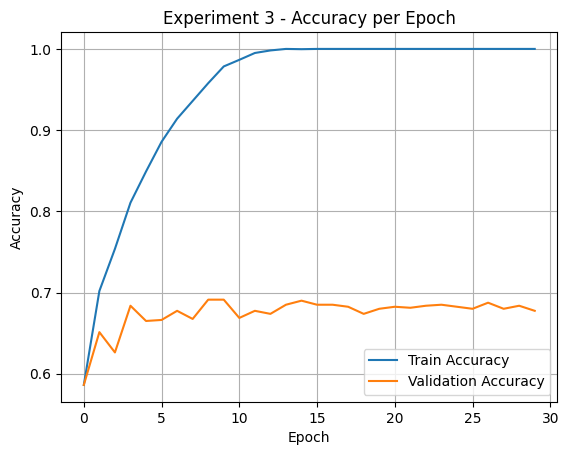

In [81]:
plt.plot(history_exp3.history['accuracy'], label='Train Accuracy')
plt.plot(history_exp3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Experiment 3 - Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

Better result! Val accuracy gets close to 69%.


## Experiment 4 - Output + Last 2 Conv Layers

Here I retrain the last two conv layers instead.  
This helps adjust deeper features for the new task.


In [82]:
# Load the original Stanford Dogs model
base_seq_model = load_model('models/stanford_dogs_multiclass_model.h5')

# Rebuild using Functional API
inputs = Input(shape=(180, 180, 3))
x = base_seq_model.layers[0](inputs)
for layer in base_seq_model.layers[1:-1]:  # Exclude the final output layer
    x = layer(x)

# Add new output layer
new_output = layers.Dense(1, activation='sigmoid')(x)

# Define the new model
model_exp4 = Model(inputs=inputs, outputs=new_output)

# Freeze all layers by default
for layer in model_exp4.layers:
    layer.trainable = False

# Unfreeze the last two Conv layers and the output layer
conv_layer_names = [l.name for l in model_exp4.layers if isinstance(l, layers.Conv2D)]
# Assume last two conv layers are:
last_conv_2 = conv_layer_names[-2:]
for layer in model_exp4.layers:
    if layer.name in last_conv_2 or layer.name.startswith('dense'):
        layer.trainable = True

# Compile the model
model_exp4.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_exp4.summary()

# Train on Cats & Dogs
history_exp4 = model_exp4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

# Save the model
model_exp4.save('models/exp4_transfer_last2conv_replaced.h5')

Model: "functional_156"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,105 (25.36 MB)

 Trainable params: 6,646,209 (25.35 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 0.5524 - loss: 1.0341 - val_accuracy: 0.6062 - val_loss: 0.6519
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.7137 - loss: 0.5547 - val_accuracy: 0.6712 - val_loss: 0.6172
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.8382 - loss: 0.4049 - val_accuracy: 0.6900 - val_loss: 0.6367
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.8941 - loss: 0.2999 - val_accuracy: 0.6850 - val_loss: 0.6958
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.9467 - loss: 0.1868 - val_accuracy: 0.6888 - val_loss: 0.7097
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.9767 - loss: 0.1267 - val_accuracy: 0.6787 - val_loss: 0.7709
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.9930 - loss: 0.0730 - val_accuracy: 0.6837 - val_loss: 0.8243
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.9978 - loss: 0

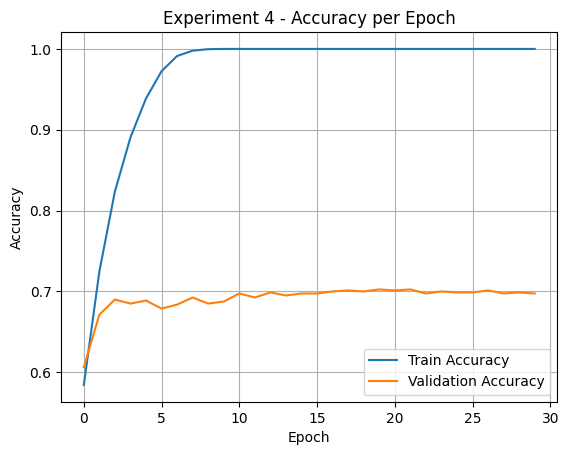

In [83]:
plt.plot(history_exp4.history['accuracy'], label='Train Accuracy')
plt.plot(history_exp4.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Experiment 4 - Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

Very similar to Exp3, val accuracy is around 70%.


## Final Thoughts

- Training from scratch gave best result.
- Transfer learning helped when I also retrained some layers.
- Changing only the output layer didn’t help much.
